In [44]:
import os

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf 
from tensorflow import keras
import keras
from keras.applications import ResNet50
from sklearn.metrics import confusion_matrix,classification_report
import warnings
warnings.filterwarnings('ignore')


In [3]:
import glob

In [4]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3

data=tf.keras.utils.image_dataset_from_directory(
    'dataset',
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,seed=42)

Found 2152 files belonging to 3 classes.


In [5]:
classnames=data.class_names

In [6]:
classnames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:

for image_batch,labels_batch in data.take(1):
    
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 2 1 1 2 0 0 1 1 1 1 0 0 1 1 0 0 2 0 0 1 0 0 0 1 0 0 1 0 2 2 0]


### Visualize some of the images from dataset

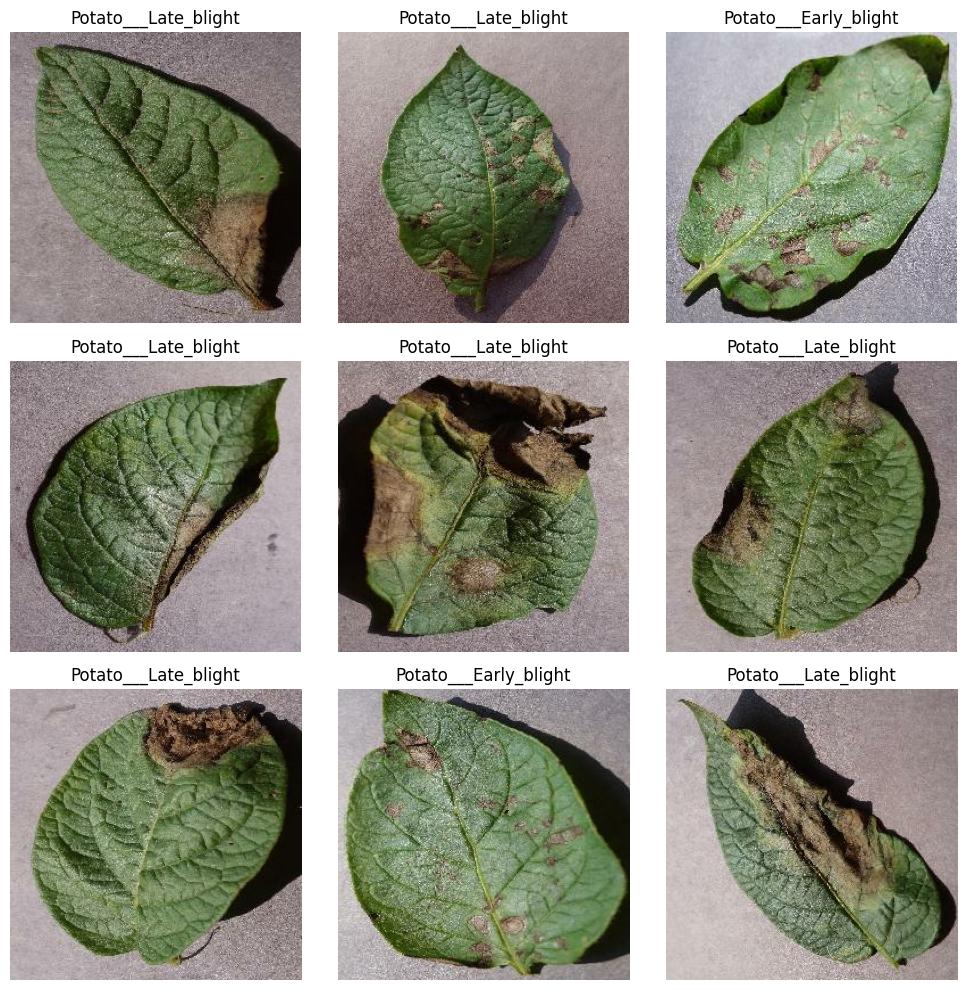

In [8]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(classnames[labels_batch[i]])
        plt.axis('off')
plt.tight_layout()
plt.show()        

### Splitting the dataset
### Training
### Validation
### Testing

In [9]:
len(data)

68

In [10]:
68*32

2176

In [11]:
# train_size=0.8
# train_data=len(data)*train_size

In [12]:
# test_data=data.skip(54)
# len(test_data)

In [13]:
# valid_size=0.1
# len(data)*valid_size

In [14]:
# val_size=test_data.take(6)
# len(val_size)

In [15]:
# test_ds=test_data.skip(6)
# len(test_data)

In [16]:
def get_dataset_partitions_tf(df,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert train_split+val_split+test_split == 1
    ds_size=len(df)
    if shuffle:
        df=df.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    # test_size=int(test_split*ds_size)

    train_df=df.take(train_size)
    val_df=df.skip(train_size).take(val_size)
    test_df=df.skip(train_size).skip(val_size)

    return train_df,val_df,test_df




In [17]:
train_df,val_df,test_df=get_dataset_partitions_tf(data)


In [18]:
len(train_df)

54

In [19]:
len(test_df)

8

In [20]:
len(val_df)

6

### Cache Shuffle and Prefetch the Dataset

In [21]:
train_df= train_df.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df= test_df.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df= val_df.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
train_df

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Resizing and Normalizing the dataset

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Resizing, Rescaling

# IMAGE_SIZE = 224  # example size, adjust as needed

resize_and_rescale = tf.keras.Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1.0 / 255)
])

In [24]:
resize_and_rescale

<Sequential name=sequential, built=False>

In [25]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [26]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation 

# IMAGE_SIZE = 224  # Replace with your desired image size

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
   
])


In [27]:
data_augmentation

<Sequential name=sequential_1, built=False>

In [28]:
# train_df=train_df.map(
    # lambda x,y : (data_augmentation(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
from tensorflow.keras import models,layers
CHANNELS=3
input_shapes=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

n_classes=3

model=models.Sequential([
    

    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shapes),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')

])

# model.build(input_shape=input_shapes)

In [30]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history=model.fit(train_df,epochs=10,batch_size=BATCH_SIZE,verbose=1,validation_data=val_df)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.4643 - loss: 5.3260 - val_accuracy: 0.4688 - val_loss: 0.9224
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5760 - loss: 0.8615 - val_accuracy: 0.6823 - val_loss: 0.7711
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.7818 - loss: 0.5743 - val_accuracy: 0.8073 - val_loss: 0.4511
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8392 - loss: 0.3958 - val_accuracy: 0.8073 - val_loss: 0.4273
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.8762 - loss: 0.3271 - val_accuracy: 0.8906 - val_loss: 0.3087
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9303 - loss: 0.1867 - val_accuracy: 0.9375 - val_loss: 0.1572
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.9502 - loss: 0.1366 - val_accuracy: 0.9271 - val_loss: 0.1528
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9576 - loss: 0.1037 - val_accuracy: 0.9531 - val_los

In [33]:
history.history

{'accuracy': [0.49016204476356506,
  0.6273148059844971,
  0.8043981194496155,
  0.8611111044883728,
  0.8767361044883728,
  0.9259259104728699,
  0.9565972089767456,
  0.9577546119689941,
  0.9571759104728699,
  0.9560185074806213],
 'loss': [2.180274486541748,
  0.8026899695396423,
  0.5357479453086853,
  0.345270574092865,
  0.3261409103870392,
  0.17845633625984192,
  0.1189057007431984,
  0.11400415003299713,
  0.11086922883987427,
  0.11799277365207672],
 'val_accuracy': [0.46875,
  0.6822916865348816,
  0.8072916865348816,
  0.8072916865348816,
  0.890625,
  0.9375,
  0.9270833134651184,
  0.953125,
  0.9375,
  0.9739583134651184],
 'val_loss': [0.9223690629005432,
  0.7711341381072998,
  0.4511270523071289,
  0.42725661396980286,
  0.3086729347705841,
  0.15719284117221832,
  0.15276949107646942,
  0.11910644918680191,
  0.13257436454296112,
  0.07839370518922806]}

In [34]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [35]:
scores=model.evaluate(test_df)

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step - accuracy: 0.9719 - loss: 0.0676


In [36]:
scores

[0.057422854006290436, 0.9765625]

In [37]:
accuracy=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


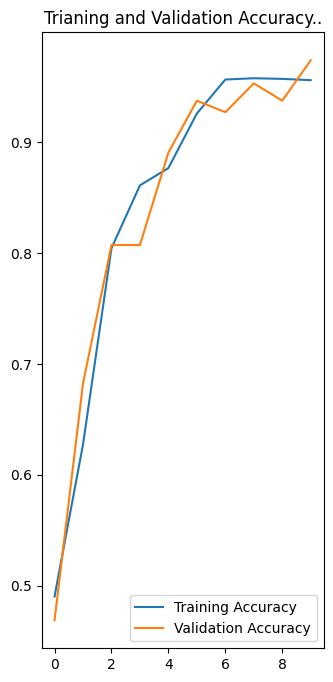

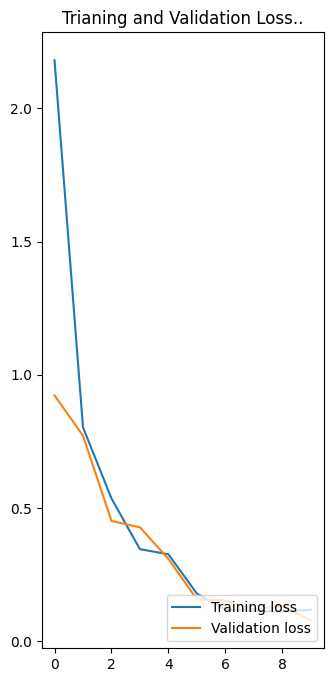

In [38]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(10),accuracy,label='Training Accuracy')
plt.plot(range(10),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Trianing and Validation Accuracy..')


plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(10),loss,label='Training loss')
plt.plot(range(10),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title('Trianing and Validation Loss..')
plt.show()

first image to predict..
first image actual label :  1
first image class label :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step
predicted label  : Potato___Late_blight


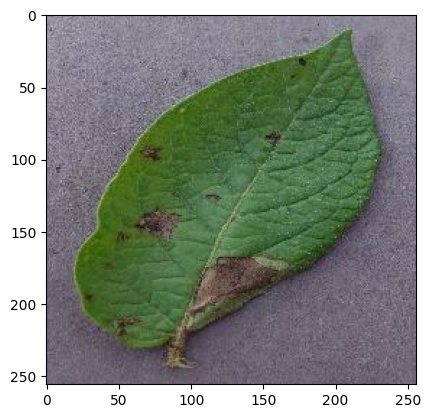

In [39]:
import numpy as np
for image_batch,label_batch in test_df.take(1):
    # plt.imshow(image_batch[0].numpy().astype('uint8'))
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0]
    print('first image to predict..')
    plt.imshow(first_image)
    print('first image actual label : ',first_label.numpy())
    print('first image class label : ',classnames[first_label])
    batch_prediction=model.predict(image_batch)
    print('predicted label  :',classnames[np.argmax(batch_prediction[0])])


In [40]:
import numpy as np
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img,0)
    prediction=model.predict(img_array)
    predicted_class=classnames[np.argmax(prediction[0])]
    confidence=round(100*(np.max(prediction[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


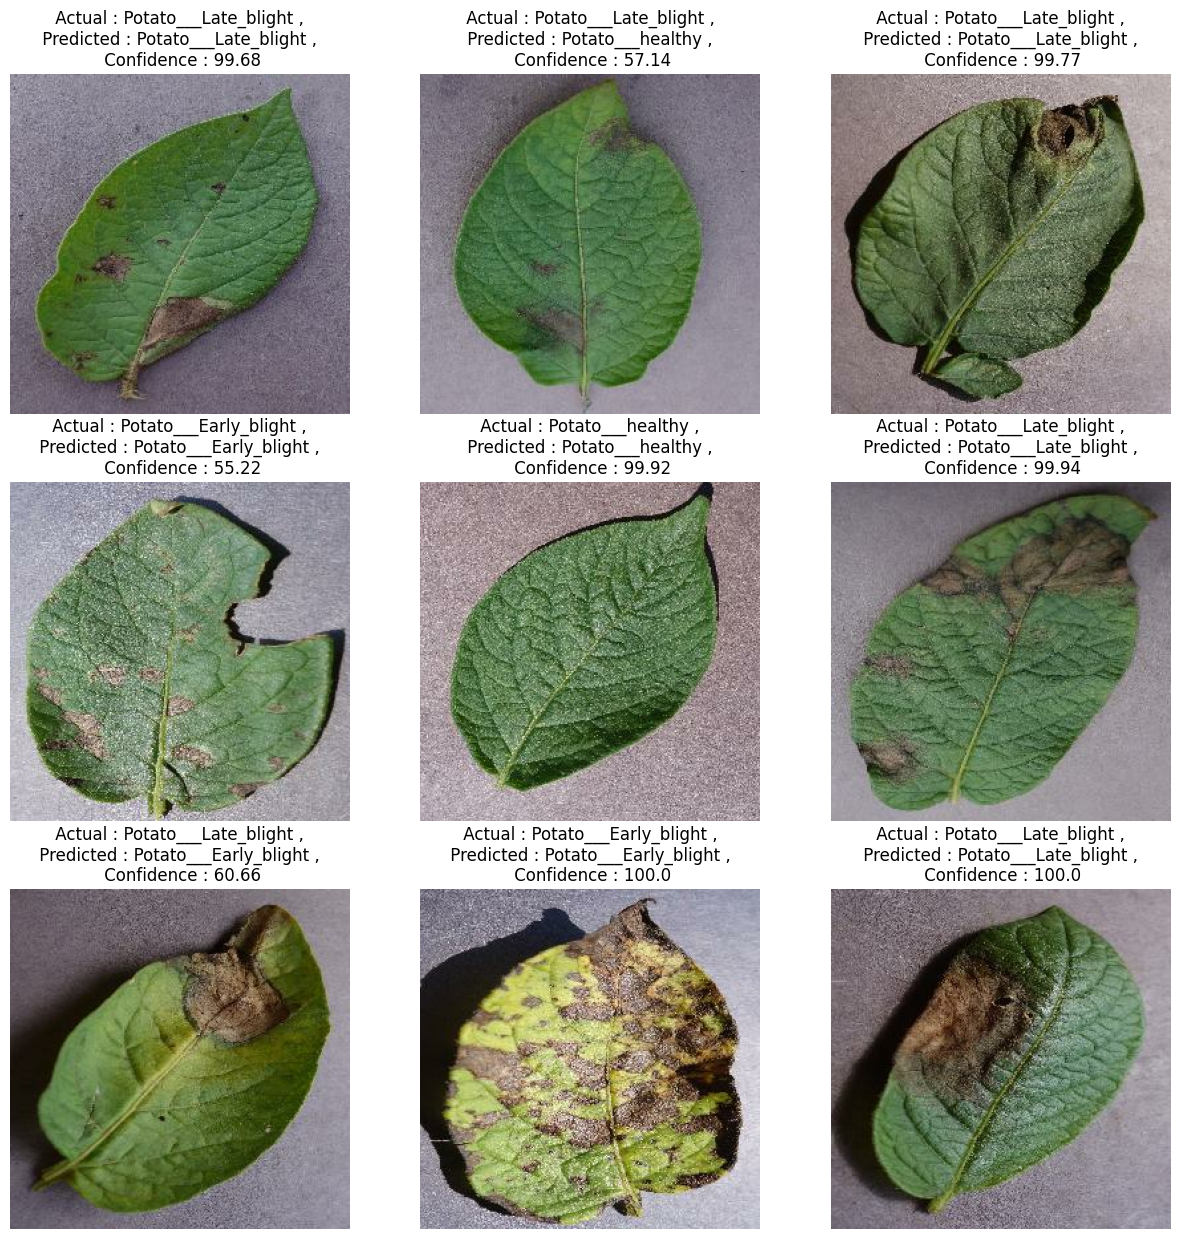

In [41]:
plt.figure(figsize=(15,15))

for images,labels in test_df.take(1):
    for i in range(9):
       
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence=predict(model,images[i])
        actual_class=classnames[labels[i]]
        plt.title(f' Actual : {actual_class} , \n Predicted : {predicted_class} , \n Confidence : {confidence}' )
        plt.axis('off')

In [42]:
# model_version=1
# model.save(f'potatos_model{model_version}.h5')

In [46]:
model_version=1
keras.saving.save_model(model, f'potatos_model.h5')